In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from partition_decode.plots import continuous_pairplot
from scipy.stats import spearmanr, kendalltau, entropy

sns.set_style('white')
sns.set_context('notebook')

In [2]:
def hidden_to_params(h, k=10, d=784):
    return (d+1) * h + (h+1) * k

def get_units_at_interp(n, k=10, d=784):
    # n k = (d+1) H + (H+1) K
    return np.ceil((n * k - k) / (d + 1 + k)).astype(int)

In [3]:
def max_eval_entropy(n, m, r):
    n = int(n)
    m = int(m)
    if r < 1:
        r = r * n * m
    X = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            X[(i+j) % n, j] = 1
            r -= 1
            if r < 1:
                break
        if r < 1:
            break
    return entropy(np.linalg.svd(X, compute_uv=False)**2)

## Network

In [111]:
#
algo = "relu_regressor"
dataset = "mnist"

# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)

# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]
df['IRM_rows_mean_L2_max'] = df.apply(
    lambda row: np.linalg.norm([1] * np.ceil(row['IRM_L1'] * row['width']).astype(int)),
    axis=1
)
df['IRM_rows_mean_L2_min'] = df.apply(
    lambda row: np.linalg.norm([row['IRM_L1']] * int(row['width'])),
    axis=1
)
df['IRM_rows_mean_L2_normalized_max'] = df['IRM_rows_mean_L2'] / df['IRM_rows_mean_L2_max']
df['IRM_rows_mean_L2_normalized_min'] = df['IRM_rows_mean_L2'] / df['IRM_rows_mean_L2_min']

# df['IRM_entropy_normalized'] = df.apply(
#     lambda row: row['IRM_entropy'] / entropy([1]*int(min(row['width'], row['n_train_samples']))),
#     axis=1)

# df['IRM_entropy_max'] = df.apply(
#     lambda row: entropy(
#         [1]*int(1 / row['IRM_L1'])
#     ),
#     axis=1
# )

df['IRM_entropy_max'] = df.apply(
    lambda row: max_eval_entropy(row['n_train_samples'], row['width'], row['IRM_L1']),
    # lambda row: entropy([1]*int(min(row['width'], row['n_train_samples']))), # 
    axis=1)

df['IRM_entropy_normalized'] = df.apply(
    lambda row: row['IRM_entropy'] / row['IRM_entropy_max'],
    axis=1)

# df['connected_partitions_fraction'] = df['IRM_L0'] / df['width']

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'hidden_layer_dims', 'n_epochs'],
    as_index=False,
).mean()
df['n_parameters'] = df['n_parameters'].astype(int)

df.head(5)

,n_train_samples,hidden_layer_dims,n_epochs,rep,n_test_samples,onehot,learning_rate,batch_size,verbose,early_stop_thresh,...,depth,width,weights_L2,generalization_gap,IRM_rows_mean_L2_max,IRM_rows_mean_L2_min,IRM_rows_mean_L2_normalized_max,IRM_rows_mean_L2_normalized_min,IRM_entropy_max,IRM_entropy_normalized
0,4000.0,4.0,1000.0,0.0,10000.0,1.0,0.01,32.0,0.0,0.0,...,1.0,4.0,2.950067,0.00595,1.000000,0.128750,0.257250,1.998059,0.028715,0.268351
1,4000.0,8.0,1000.0,0.0,10000.0,1.0,0.01,32.0,0.0,0.0,...,1.0,8.0,4.286289,0.02085,1.000000,0.122418,0.247784,2.024080,0.097337,7.156528
2,4000.0,12.0,1000.0,0.0,10000.0,1.0,0.01,32.0,0.0,0.0,...,1.0,12.0,5.448966,0.03790,1.000000,0.221125,0.344719,1.558934,0.096760,16.515491
3,4000.0,16.0,1000.0,0.0,10000.0,1.0,0.01,32.0,0.0,0.0,...,1.0,16.0,6.646698,0.06735,1.414214,0.275625,0.294996,1.513605,0.118444,16.355383
4,4000.0,24.0,1000.0,0.0,10000.0,1.0,0.01,32.0,0.0,0.0,...,1.0,24.0,8.265626,0.10560,1.414214,0.328283,0.403121,1.736609,0.177589,11.425097


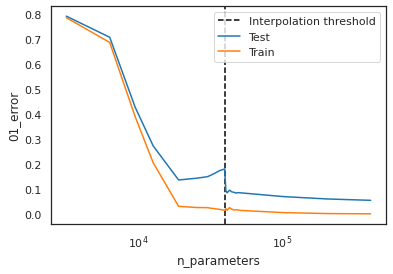

In [112]:
plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='Interpolation threshold')

sns.lineplot(
    data=plot_df, x='n_parameters', y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x='n_parameters', y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

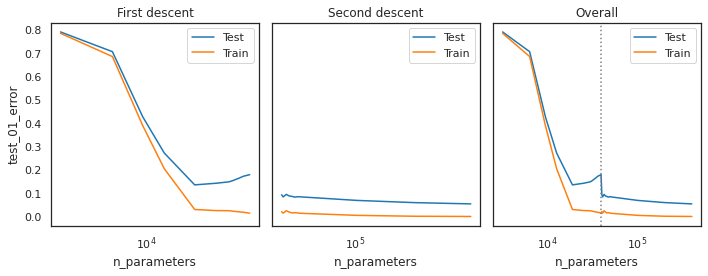

,First_descent,Second_descent,Overall
generalization_gap,1.000000,1.000000,1.000000
IRM_L1,-0.824176,-0.569478,-0.615351
IRM_L2,-0.978022,-0.510252,-0.771472
n_regions,1.000000,-0.643836,-0.079600
ACTS_L2,-0.857143,0.698630,0.108308
IRM_entropy,0.983516,-0.674261,-0.085236
IRM_entropy_normalized,-0.516484,0.628703,-0.388345
IRM_rows_mean_L2_min,0.170330,-0.646927,-0.241792
IRM_rows_mean_L2_max,0.731925,-0.691778,-0.191603
IRM_rows_mean_L2,0.802198,-0.660594,-0.113503


In [113]:
## Correlation variables
corr_vars = [
    'generalization_gap', # test_error,
    # 'n_parameters', 'width',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    # 'IRM_h*', 'ACTS_h*',
    'IRM_entropy', 'IRM_entropy_normalized',
    'IRM_rows_mean_L2_min',
    'IRM_rows_mean_L2_max',
    'IRM_rows_mean_L2',
    'IRM_rows_mean_L2_normalized_min',
    'IRM_rows_mean_L2_normalized_max',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

x_var = 'n_parameters'
plot_df = df

interp = 10*df['n_train_samples'].iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

for ax, idx, title in zip(
    axes,
    (
        df[x_var] <= interp,
        df[x_var] >= interp,
        df[x_var] > 0,
    ),
    ('First descent', 'Second descent', 'Overall')
):
    plot_df = df[idx]
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax, label='Train')
    ax.set_xscale('log')
    ax.set_title(title)

axes[2].axvline(interp, ls=':', c='grey', label='Interpolation threshold')
plt.tight_layout()
plt.show()

corr_df = df[df[x_var] <= interp][corr_vars].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp][corr_vars].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df[corr_vars].corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']
display(corr_df)

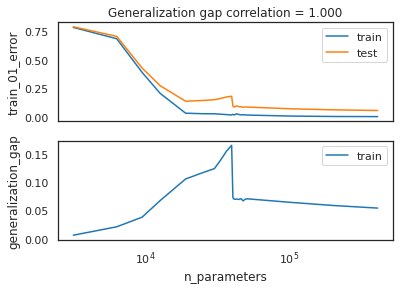

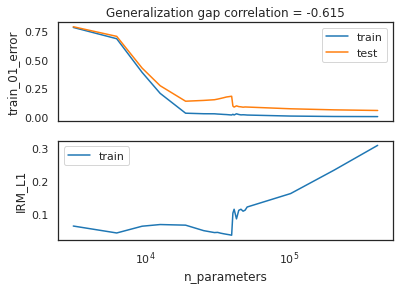

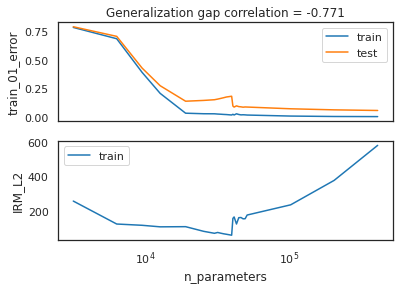

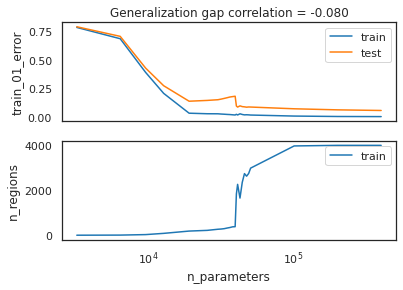

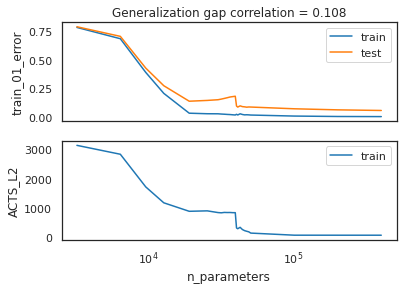

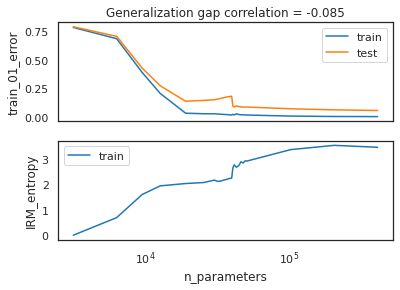

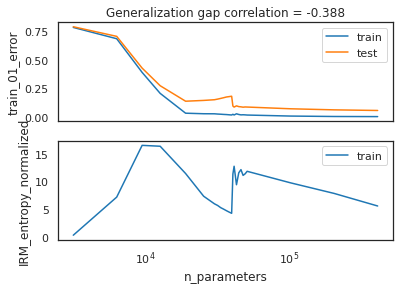

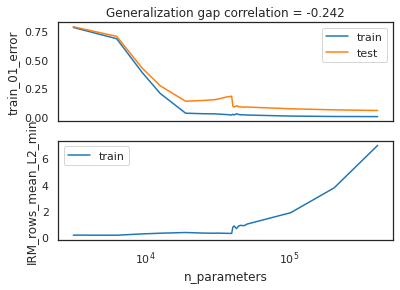

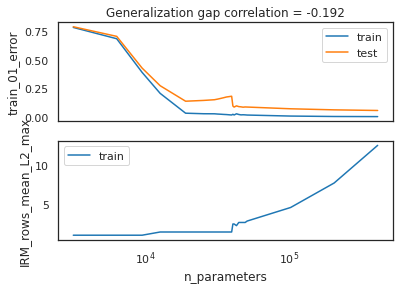

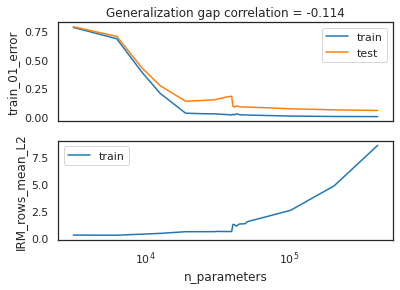

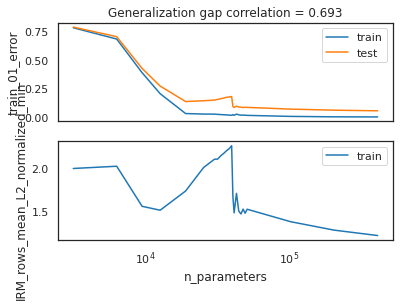

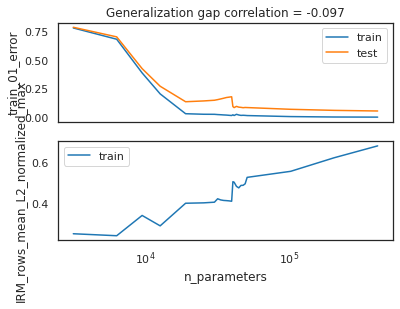

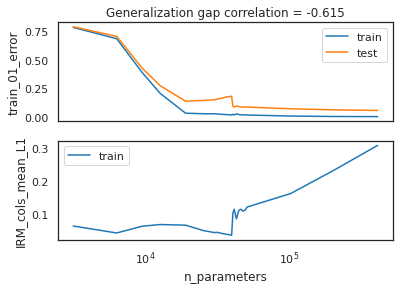

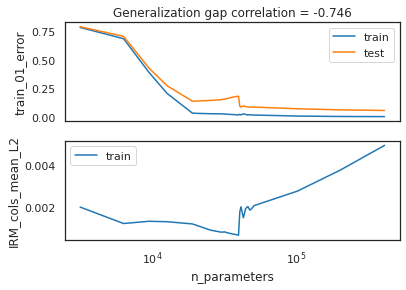

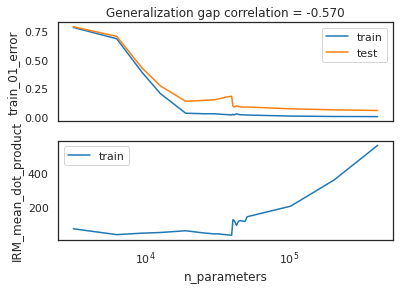

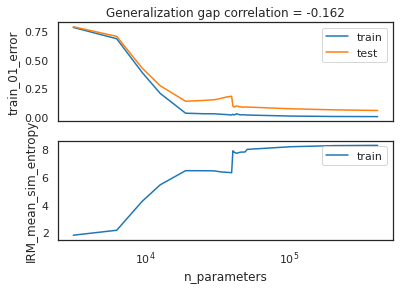

In [114]:
for var in corr_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    sns.lineplot(
        data=plot_df, x='n_parameters', y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x='n_parameters', y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x='n_parameters', y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    
#     if var in ['connected_partitions_fraction']:
#         ax2.set_yscale('symlog', linthresh=1e-2)
#     else:
    # ax2.set_yscale('log')
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()

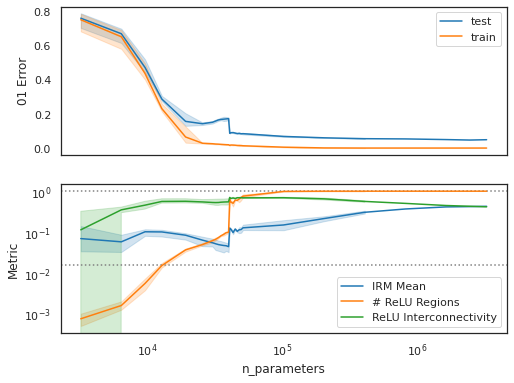

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

plot_df = df.copy()
plot_df["n_regions"] = plot_df["n_regions"] / plot_df["n_train_samples"]
plot_df["ACTS_L2"] = plot_df["ACTS_L2"] / plot_df["n_train_samples"]

ax2.axhline(1, ls=':', c='grey')
ax2.axhline(
    1 / np.sqrt(plot_df[plot_df["rep"] == 0]['n_train_samples'].iloc[0]),
    ls=':', c='grey')

x_var = 'n_parameters'
sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax1, label='test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax1, label='train')

x_var = 'n_parameters'
sns.lineplot(
    data=plot_df, x=x_var, y='IRM_L1',
    ax=ax2, label='IRM Mean')
sns.lineplot(
    data=plot_df, x=x_var, y="n_regions",
    ax=ax2, label="# ReLU Regions")
sns.lineplot(
    data=plot_df, x=x_var, y="IRM_entropy_normalized",
    ax=ax2, label="ReLU Interconnectivity")

# ax2.plot(
#     plot_df[plot_df["rep"] == 0]["n_parameters"],
#     1 / plot_df[plot_df["rep"] == 0]["width"],
#     ls='--', c='black', label='1/# Relus')

# sns.lineplot(
#     data=plot_df, x='n_parameters', y="width",
#     ax=ax3, label="# ReLUs")

ax1.set_xscale('log')
ax1.set_ylabel('01 Error')

ax2.set_yscale('log')#, linthresh=1e-3)
ax2.set_ylabel("Metric")
# ax2.set_xscale('log')

plt.legend()
plt.show()

## notepad

Thoughts:
- region complexity should be L1 (a parameter in one region moved to another should be the same overall complexity for equal sized regions)

- size complexity should be L1?

Metric notes:

- metric = sum_{unique regions} (size * region complexity) = sum_{regions} region_complexity = sum of matrix = col_mean_L1 * n_samples

- metric = col_mean_L2 ~ sum_{regions} region_complexity^2 = sum_{unique_regions} size * region_complexity^2

## Forest

In [124]:
#
algo = "forest"
dataset = "mnist"

# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results.csv')


# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["n_estimators"] / df["n_total_leaves"]

# Fixed columns
df['IRM_rows_mean_L2_max'] = df.apply(
    lambda row: np.linalg.norm([1]*int(row['n_estimators'])),
    # lambda row: np.linalg.norm([1] * np.ceil(row['IRM_L1'] * row['n_estimators'] * row['n_train_samples']).astype(int)),
    axis=1
)
df['IRM_rows_mean_L2_min'] = df.apply(
    lambda row: np.linalg.norm([1/row['n_train_samples']]*int(row['n_train_samples'] * row['n_estimators'])),
    # lambda row: np.linalg.norm([row['IRM_L1']] * int(row['n_total_leaves'])),
    axis=1
)

# Adaptive columns
# df['IRM_rows_mean_L2_max'] = df.apply(
#     lambda row: np.linalg.norm([1] * int(row['n_estimators'])),
#     axis=1
# )
# df['IRM_rows_mean_L2_min'] = df.apply(
#     lambda row: np.linalg.norm([1 / row['n_train_samples']] * int(row['n_train_samples'] * row['n_estimators'])),
#     axis=1
# )
df['IRM_rows_mean_L2_normalized_max'] = df['IRM_rows_mean_L2'] / df['IRM_rows_mean_L2_max']
df['IRM_rows_mean_L2_normalized_min'] = df['IRM_rows_mean_L2'] / df['IRM_rows_mean_L2_min']

df['IRM_entropy_max'] = df.apply(
    lambda row: entropy([1]*int(min(row['n_total_leaves'], row['n_train_samples']))),
    axis=1)

df['IRM_entropy_normalized'] = df.apply(
    lambda row: row['IRM_entropy'] / row['IRM_entropy_max'],
    axis=1)

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'max_depth', 'n_estimators'],
    as_index=False,
).mean()

# max_leaves = df.loc[
#     (df['n_estimators'] == 1) & (df['max_depth'] != 'None'),
#     'max_depth'
# ].astype(int).max()
# df['forest_capacity'] = df['']

# df.loc[
#     (df['n_estimators'] > 1) & (df['max_depth'] != 'None'),
#     'max_depth'
# ] = max_leaves

# df['n_max_leaves'] = max_leaves * df['n_estimators']

df.head(5)

,model,n_train_samples,max_depth,n_estimators,rep,n_test_samples,onehot,bootstrap,n_jobs,train_01_error,...,IRM_mean_dot_product,IRM_mean_sim_entropy,n_total_leaves,generalization_gap,IRM_rows_mean_L2_max,IRM_rows_mean_L2_min,IRM_rows_mean_L2_normalized_max,IRM_rows_mean_L2_normalized_min,IRM_entropy_max,IRM_entropy_normalized
0,forest,1000.0,1,1.0,1.0,10000.0,1.0,0.0,-2.0,0.784333,...,526.725333,6.241839,2.000000,0.000540,1.0,0.031623,0.725525,22.943129,0.693147,0.960714
1,forest,1000.0,10,1.0,1.0,10000.0,1.0,0.0,-2.0,0.020667,...,36.865333,2.858613,174.333333,0.066429,1.0,0.031623,0.191829,6.066181,5.160004,0.784716
2,forest,1000.0,11,1.0,1.0,10000.0,1.0,0.0,-2.0,0.005333,...,34.870000,2.760178,192.666667,0.071682,1.0,0.031623,0.186684,5.903472,5.260689,0.788438
3,forest,1000.0,12,1.0,1.0,10000.0,1.0,0.0,-2.0,0.002333,...,35.640667,2.797903,190.000000,0.072403,1.0,0.031623,0.188774,5.969547,5.247015,0.783277
4,forest,1000.0,13,1.0,1.0,10000.0,1.0,0.0,-2.0,0.000000,...,32.889333,2.696351,202.333333,0.073767,1.0,0.031623,0.181192,5.729785,5.309301,0.793189


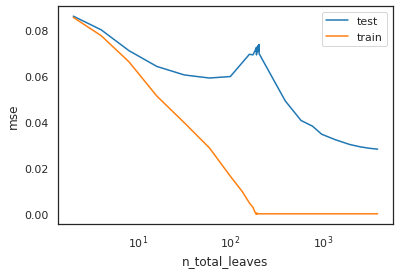

In [125]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

x_var = 'n_total_leaves'
sns.lineplot(
    data=df, x=x_var, y=test_error,
    ax=ax, label='test')
sns.lineplot(
    data=df, x=x_var, y=train_error,
    ax=ax, label='train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

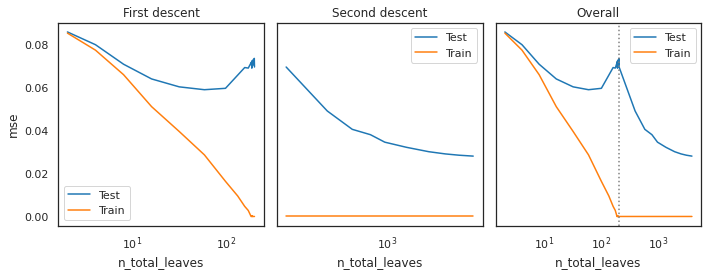

,First_descent,Second_descent,Overall
generalization_gap,1.000000,1.000000,1.000000
IRM_L0,0.727293,-0.937437,0.111888
IRM_L1,-0.730367,-0.163636,-0.560121
IRM_L2,-0.620022,0.975758,-0.061134
n_regions,0.727293,-1.000000,0.109345
ACTS_L2,-0.620022,1.000000,-0.060729
IRM_entropy,0.658287,-1.000000,0.078138
IRM_entropy_normalized,-0.664516,0.175758,-0.097571
IRM_rows_mean_L2_min,NaN,-1.000000,-0.469421
IRM_rows_mean_L2_max,NaN,-1.000000,-0.469421


In [126]:
## Correlation variables
corr_vars = [
    'generalization_gap',
    # test_error,
#     'n_total_leaves', 'n_estimators',
    'IRM_L0', 'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    # 'IRM_h*', 'ACTS_h*',
    'IRM_entropy', 'IRM_entropy_normalized',
    'IRM_rows_mean_L2_min',
    'IRM_rows_mean_L2_max',
    'IRM_rows_mean_L2',
    'IRM_rows_mean_L2_normalized_min',
    'IRM_rows_mean_L2_normalized_max',
#     'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]



x_var = 'n_total_leaves'
# U_argmin = 700
interp = df[df['n_estimators']==1]['n_total_leaves'].max()

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
# Join ascent/second descent y-axes
# axes[1].get_shared_y_axes().join(axes[1], axes[2])

for ax, idx, title in zip(
    axes,
    (
        df[x_var] <= interp,
        # (df[x_var] >= U_argmin) & (df[x_var] <= interp),
        df[x_var] >= interp,
        df[x_var] > 0,
    ),
    ('First descent', 'Second descent', 'Overall')
):
    plot_df = df[idx]
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax, label='Train')
    ax.set_xscale('log')
    ax.set_title(title)

# axes[3].axvline(df[df[x_var] == U_argmin][x_var].iloc[0], ls=':', c='grey', label='U argmin')
axes[2].axvline(interp, ls=':', c='grey', label='Interpolation threshold')
axes[0].set_ylabel(metric)
plt.tight_layout()
plt.show()

corr_df = df[df[x_var] <= interp][corr_vars].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp][corr_vars].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df[corr_vars].corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

display(corr_df)

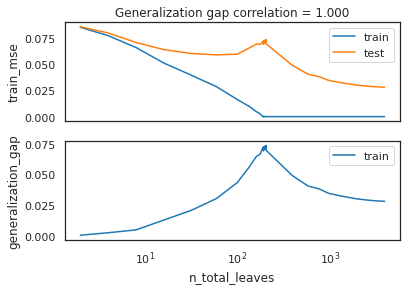

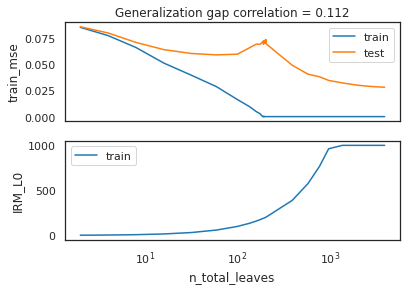

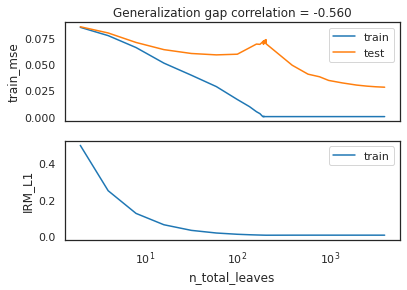

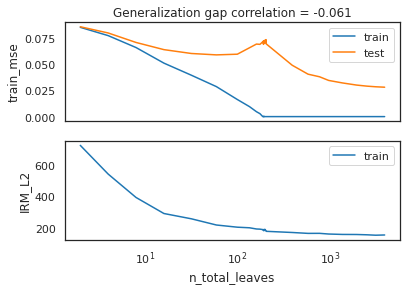

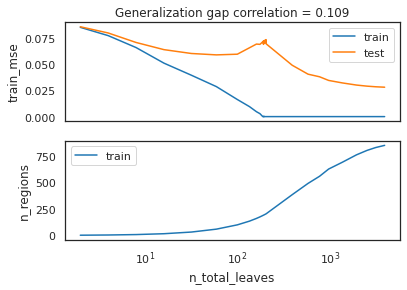

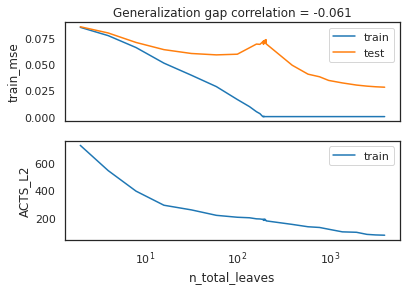

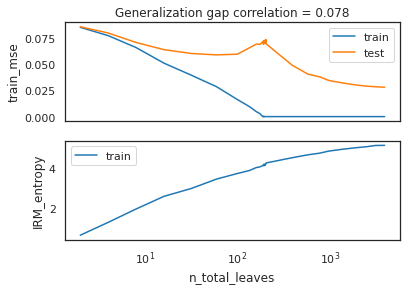

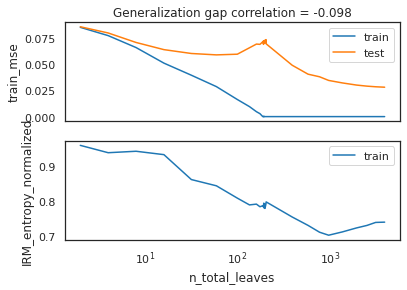

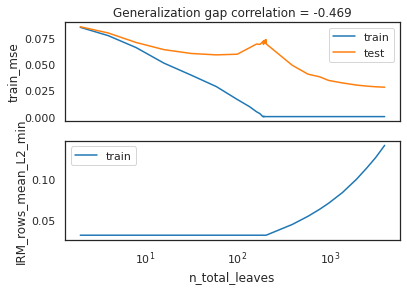

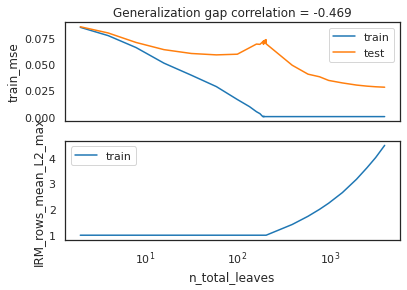

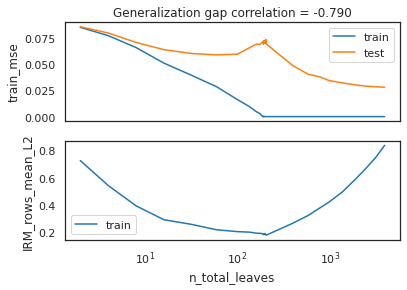

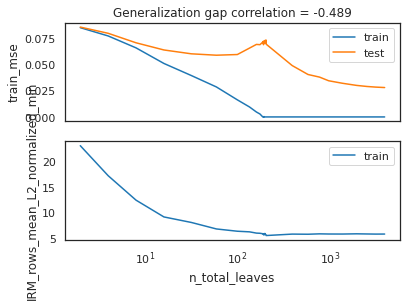

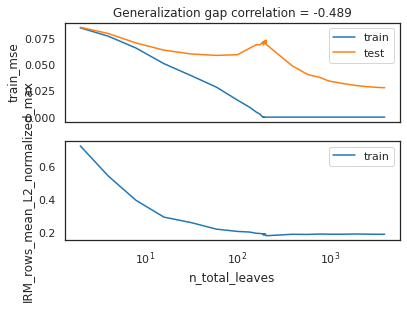

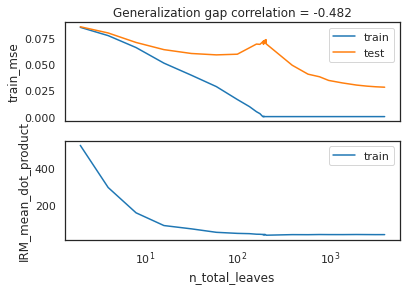

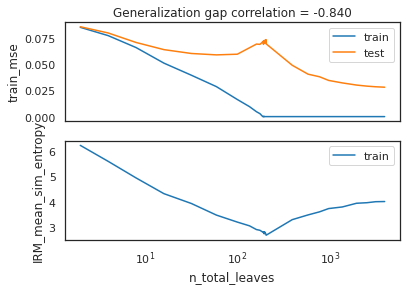

In [127]:
plot_df = df# [df['n_estimators'] > 1]
x_var = 'n_total_leaves'

for var in corr_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x=x_var, y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    
#     if var in ['connected_partitions_fraction']:
#         ax2.set_yscale('symlog', linthresh=1e-2)
#     else:
    # ax2.set_yscale('log')
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()

## Random relu features

In [129]:
#
algo = "rrf"
dataset = "mnist"

# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results.csv')

# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]


# df['IRM_entropy_max'] = df.apply(
#     lambda row: entropy([1]*int(min(row['out_features'], row['n_train_samples']))),
#     axis=1)

# df['IRM_entropy_normalized'] = df.apply(
#     lambda row: row['IRM_entropy'] / row['IRM_entropy_max'],
#     axis=1)

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'out_features'],
    as_index=False,
).mean()

# df['connected_partitions_fraction'] = df['IRM_L0'] / df['width']

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'out_features'],
    as_index=False,
).mean()

df.head(5)

,model,n_train_samples,out_features,rep,n_test_samples,onehot,alpha,max_iter,batch_size,learning_rate_init,...,ACTS_L2,IRM_h*,ACTS_h*,IRM_entropy,IRM_rows_mean_L2,IRM_cols_mean_L1,IRM_cols_mean_L2,IRM_mean_dot_product,IRM_mean_sim_entropy,generalization_gap
0,rrf,1000.0,10.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,101.341008,10.0,0.0,1.350627,1.758024,0.50650,0.016753,30.906490,6.824472,0.232782
1,rrf,1000.0,20.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,34.928498,1.0,0.0,1.613812,2.554790,0.51170,0.016455,16.317375,6.883045,0.652788
2,rrf,1000.0,50.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,31.622777,1.0,0.0,1.796147,4.187792,0.52488,0.016719,7.015042,6.897560,0.631598
3,rrf,1000.0,100.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,31.622777,1.0,0.0,2.131789,5.694178,0.50652,0.016078,3.242367,6.900806,0.922784
4,rrf,1000.0,200.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,31.622777,1.0,0.0,2.468658,7.773384,0.49628,0.015727,1.510637,6.902289,1.018869


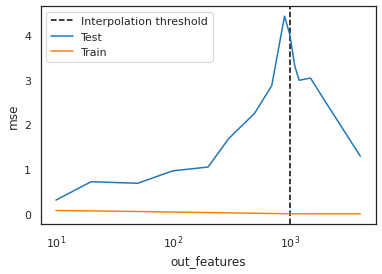

In [130]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

ax.axvline(df['n_train_samples'].iloc[0], ls='--', c='black', label='Interpolation threshold')
x_var = 'out_features'

sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

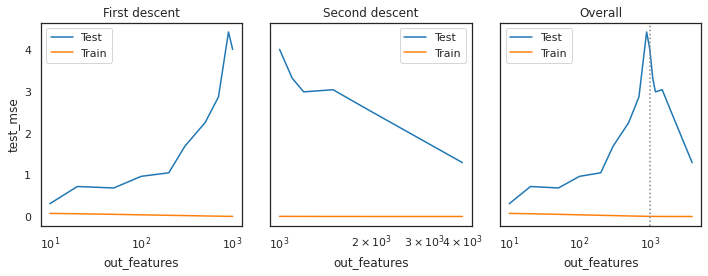

,First_descent,Second_descent,Overall
generalization_gap,1.000000,1.000000,1.000000
test_mse,1.000000,1.000000,1.000000
out_features,0.975758,-0.942857,0.692857
IRM_L1,-0.103030,0.600000,0.039286
IRM_L2,-0.503030,0.542857,-0.257143
n_regions,0.622799,NaN,0.549350
ACTS_L2,-0.622799,NaN,-0.549350
IRM_h*,-0.522233,NaN,-0.433013
ACTS_h*,NaN,NaN,NaN
IRM_entropy,0.951515,-1.000000,0.671429


In [131]:
## Correlation variables
corr_vars = [
    'generalization_gap', test_error,
    'out_features',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

x_var = 'out_features'
# U_argmin = 700
interp = df['n_train_samples'].iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
# Join ascent/second descent y-axes
# axes[1].get_shared_y_axes().join(axes[1], axes[2])

for ax, idx, title in zip(
    axes,
    (
        df[x_var] <= interp,
        # (df[x_var] >= U_argmin) & (df[x_var] <= interp),
        df[x_var] >= interp,
        df[x_var] > 0,
    ),
    ('First descent', 'Second descent', 'Overall')
):
    plot_df = df[idx]
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax, label='Train')
    ax.set_xscale('log')
    ax.set_title(title)

# axes[3].axvline(df[df[x_var] == U_argmin][x_var].iloc[0], ls=':', c='grey', label='U argmin')
axes[2].axvline(interp, ls=':', c='grey', label='Interpolation threshold')
plt.tight_layout()
plt.show()

corr_df = df[df[x_var] <= interp][corr_vars].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp][corr_vars].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df[corr_vars].corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

display(corr_df)

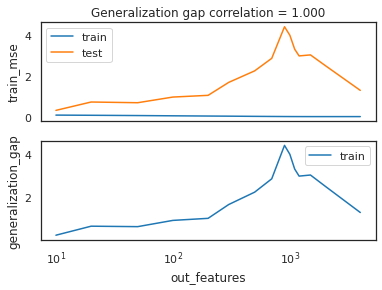

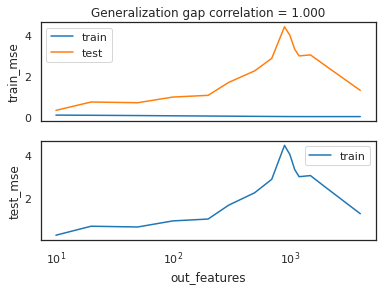

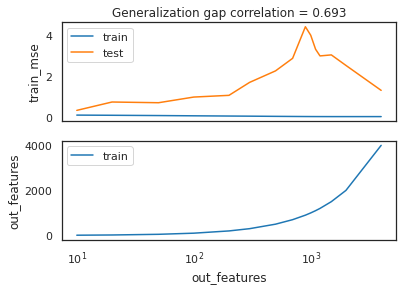

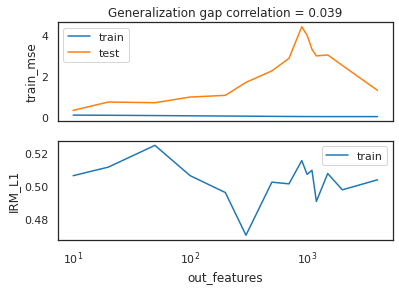

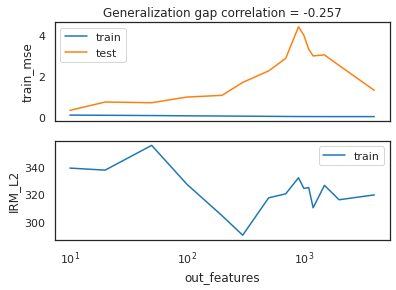

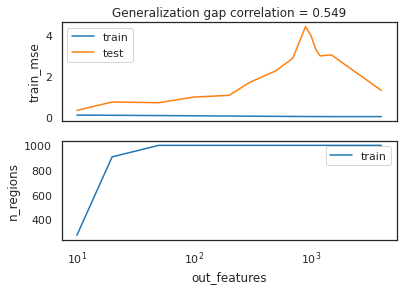

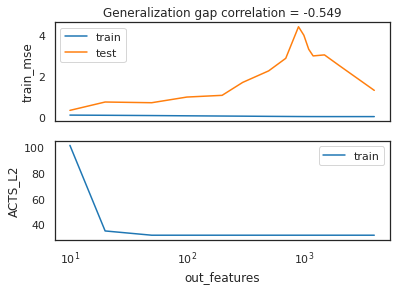

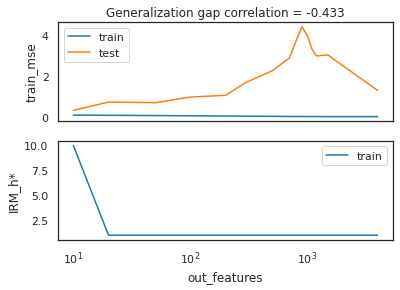

/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


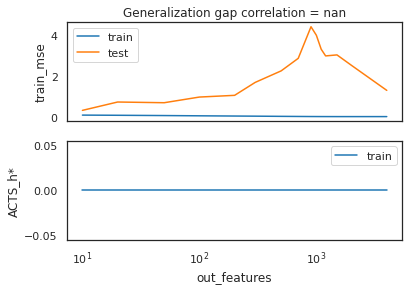

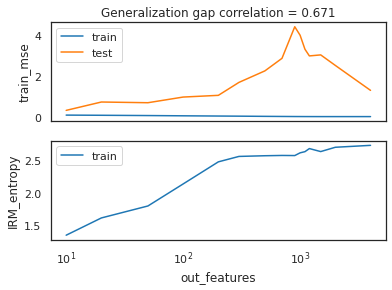

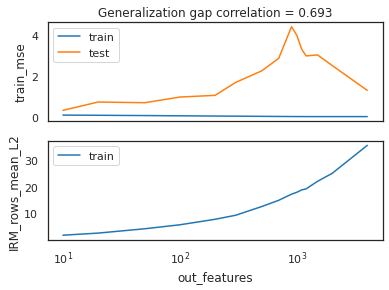

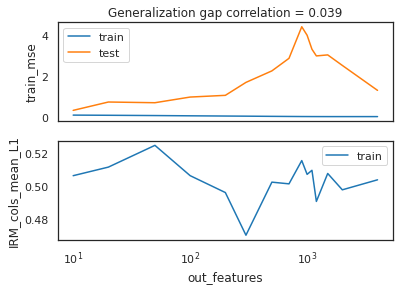

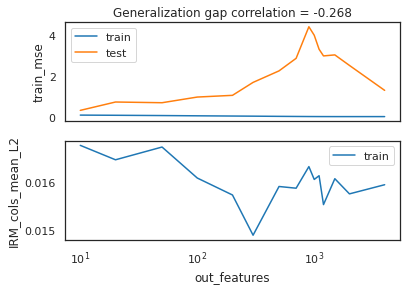

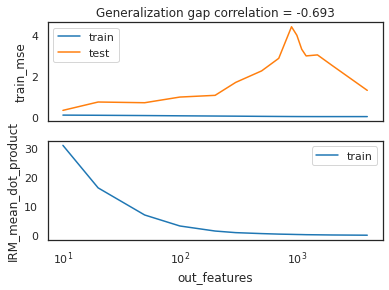

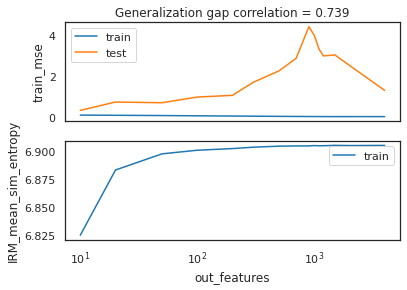

In [132]:
for var in corr_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    x_var = 'out_features'
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x=x_var, y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    
#     if var in ['connected_partitions_fraction']:
#         ax2.set_yscale('symlog', linthresh=1e-2)
#     else:
    # ax2.set_yscale('log')
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()